## 卷积神经网络
ConvNet是一种空间上共享参数的神经网络。  
CNN相较于传统的图像处理算法的优点之一在于，避免了对图像复杂的前期预处理过程(提取人工特征等)，可以直接输入原始图像。已经在诸如图像识别和分类的领域证明了其高效的能力。  

**定义一个基本的卷积神经网络：**(1)卷积层;(2)池化层(可选);(3)输出层。
### 1. 图像  
本质上说，每张图像都可以表示为像素值的矩阵，存储每个表示位置像素的颜色码，数值为0到255。0表示最暗，255表示最亮。每张图像都是一系列特定排序的图点(像素)。如果改变像素的顺序或数值，图像也随之改变。  

图像处理中，往往将图像看成一个或多个堆叠在一起的二维向量，如MNIST手写体图片，就可以看作一个28*28的二维向量(黑白图片，只有一个颜色通道；如果是RGB表示的彩色图片则有三个颜色通道，红绿蓝三原色的光以不同比例相加，可以产生多种多样的色光。可将其表示为三个二维向量(三维张量))。  

### 2. 卷积
卷积神经网络的名字就来源于其中的卷积操作。卷积的主要目的是为了从输入图像中提取特征。卷积可以通过从输入的一小块数据中学到图像的特征，并可以保留像素的空间关系。

** 分解一张图片**  

CNN的第一步是把图片分成小块。我们通过选取一个给定宽度和高度的滤波器来实现这一步。  
滤波器会照在图片的小块patch(图像区块)上。这些patch的大小和滤波器一样大。  

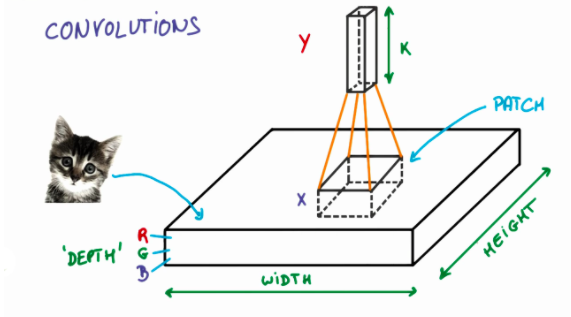

In [7]:
from IPython.display import Image
Image("19.png")

如图，CNN用滤波器来把图片分割成更小的patch, patch的大小跟滤波器大小相同。  
我们可以在水平方向，或者竖直方向滑动滤波器对图片的不同部分进行聚焦。  

滤波器滑动的间隔被称作**stride(步长)**。这是你可以调节的一个超参数。增大stride值后，会减少每层总patch数量，因此也减小了模型大小。通常这也会降低图像静度。  

这里最重要的是我们把相邻的像素聚在一起，把它们视作一个集合。  
在普通非卷机的神经网络中，我们忽略了这种临近性。在普通网络中，我们把输入图片中的每一个像素与下一层的神经元相连。图片中相邻像素在一起是有原因的，并且有着特殊意义，但普通网络没有有效利用好这些信息。  

要利用这种临近结构，我们的CNN就要学习如何分类临近模式。  

### 滤波器深度 Filter Depth
通常都会有多于一个滤波器，不同滤波器提取一个patch的不同特性。例如，一个滤波器寻找特定颜色，另一个寻找特定物体的特定形状。卷积层滤波器的数量被称为滤波器深度。  

- 每个patch连接多少神经元？  
这取决于滤波器的深度，如果深度是k，我们把每个patch与下一层的 k个神经元相连。这样下一层的高度就是k，如上图。实际操作中，k是一个我们可以调节的超参数，大多数CNNs 倾向于选择相同的起始值。  

- 为什么把一个batch与下一层的多个神经元相连呢？一个神经元不好吗？  
多个神经元的作用在于，一个狗的patch可以有多个有意义的，可供提取的特点。  
例如，一个patch可能包括白牙、金色的须、红舌头的一部分。在这种情况下，我们需要一个深度至少为3的滤波器，一个识别牙、一个识别须、一个识别舌头。 

一个patch连接有多个神经元可以保证我们的CNNs学会提取任何它觉得重要的特征。  
记住，CNN并没有被规定寻找特定特征。与之相反，它**自我学习**什么特征值值得注意。  

## 参数共享

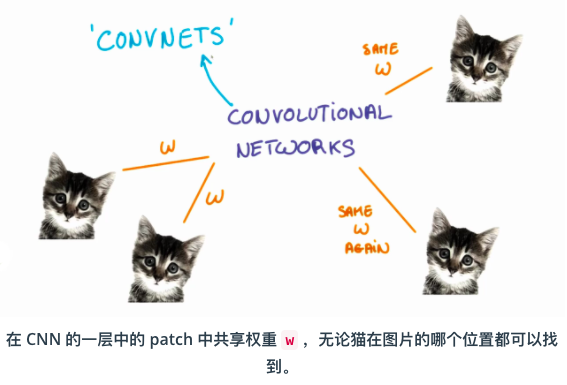

In [6]:
from IPython.display import Image
Image("18.png")

当我们试图识别一个猫的图片时，我们并不在意猫出现在哪个位置。无论是左上角、右下角，它在你眼里都是一只猫。因此我们希望CNNs能够无差别的识别。这如何做到呢？  

一个给定的patch的分类，是由patch对应的权重和偏置项决定的。  
如果我们想让左上角的猫与右下角的猫以同样的方式被识别，他们的权重和偏置项需要一样，这样他们才能以同一种方法识别。   

这正是我们在CNNs中做的。一个给定输出层学到的权重和偏置项会共享在输出层所有的patch里。注意，当我们增大滤波器的深度时，我们需要学习的权重和偏置项的数量也会增加，因为权重并没有共享在所有输出的channel里。  

共享参数还有一个额外的好处。如果我们不在所有的 patch 里用相同的权重，我们必须对每一个 patch 和它对应的隐藏层神经元学习新的参数。这不利于规模化，特别对于高清图片。  
因此，**共享权重不仅帮我们平移不变，还给我们一个更小，可以规模化的模型**。

### padding

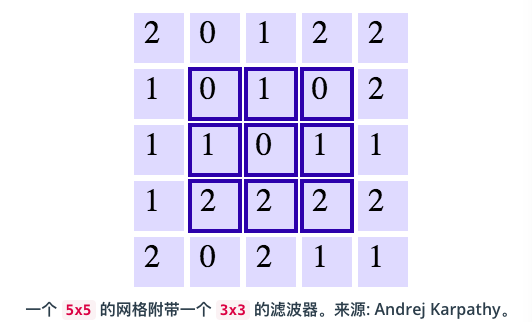

In [5]:
from IPython.display import Image
Image("20.png")

假设现在有一个$5\times 5$网格和一个尺寸为$3\times 3$ stride值为1的滤波器(filter)。下一层的width和height是多少呢？如图中所示，在水平和数值方向都可以在3个不同的位置放置patch,下一层的维度即为$3\times 3$，下一层的宽和高的尺寸就会按此规则缩放。 

在理想状态下，我们可以在层间保持相同的宽度和高度，以便继续添加图层，保持网络的一致性，而不用担心维度的缩小。  
- 如何实现？  
一种简单的办法是在$5\times 5$的原始图片外层包裹一圈0.如下图：


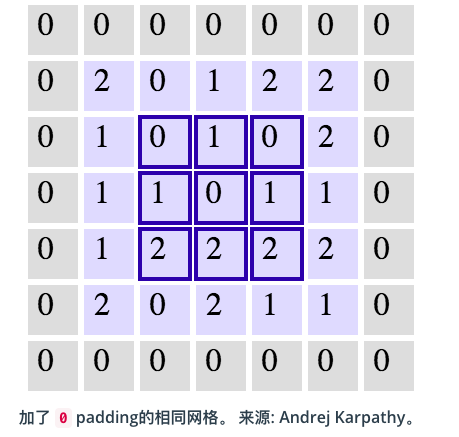

In [8]:
from IPython.display import Image
Image("21.png")

这将会把原始图片扩展到$7\times 7$.现在我们知道如何让下一层图片的尺寸维持在$5\times 5$,保持维度的一致性。  
### 维度  
- 如何计算CNN中每一层神经元的数量呢？  
输入层的维度值为 W，滤波器的维度值为 F (height$\times$width$\times$depth), stride的数值为S, padding的数值为P，下一层的维度值可用如下公式表示：(W-F+2P)/S+1。  

我们可以通过每一层神经元的维度信息，得知模型的规模，并了解到我们设定的 filter size 和 stride 如何影响整个神经网络的尺寸。  
### 设置  
H = height, W = width, D = depth

- 我们有一个输入维度是 32x32x3 ($H\times W\times D$)  
- 20个维度为 8x8x3 ($H\times W\times D$) 的滤波器  
- 高和宽的stride（步长）都为 2。(S)  
- padding 大小为1 (P)  

计算新的高度和宽度的公式是：   

new_height = (input_height - filter_height + 2*p)/S+1  

new_width = (input_width - filter_width + 2*p)/S+1   

- 卷积层输出维度是什么？  
**$14\times 14\times 20$**  

** 记住，新的深度与滤波器数量相同，都是20**  

>- 卷积层有多少参数（没有参数共享情况下）？  
**答：**没有权值共享时，滤波器中的每一个参数与输出的每一个神经元都相连。所以我们需要做的是计算滤波器总计的参数数量，以及输出的总神经元数量。  
$$(8*8*3+1)*(14*14*20) = 756560  $$  
8*8*3是权值数量，加上1作为bias。因为每一个权值都与输出的每一部分相连，所以我们把这两个数相乘得到最后答案。    
>- 如果输出层的每个神经元与其它同样通道的神经元共享参数，现在计算卷积层的参数数量。  
这是实际卷积层(tf.nn.conv2d())使用的参数数量。  
**提示：**
有了参数共享，每个输出通道的神经元与相同通道的其它神经元共享权值。参数的数量与滤波器神经元的数量相同，加上偏置，再乘以输出层的通道数。  
**答：** $$(8*8*3+1)*20 = 3860  $$   
3840个权值与20个偏置。记住，有了权值共享，一整个深度切片，我们用同一个滤波器。所以我们可以拿掉 14*14 只留下20.

## TensorFlow 卷积层
TensorFlow提供了 tf.nn.conv2d()和 tf.nn.bias_add()函数来创建卷积层。

In [11]:
import tensorflow as tf

# output depth
k_output = 64

# Image properties
image_width = 10
image_height = 10
color_channels = 3

# Convolution filter
filter_size_width = 5
filter_size_height = 5

# Input/Image
input = tf.placeholder(tf.float32,shape = [None, image_height,image_width, color_channels])

# weight and bias
weight =tf.Variable(tf.truncated_normal([filter_size_height,filter_size_width,
                                       color_channels,k_output]))
bias = tf.Variable(tf.zeros(k_output))

# Apply convolution
conv_layer = tf.nn.conv2d(input, weight, strides = [1,2,2,1], padding = 'SAME')

# Add bias
conv_layer = tf.nn.bias_add(conv_layer, bias)

# Apply activation function
conv_layer = tf.nn.relu(conv_layer)

上述代码用了 tf.nn.conv2d( )函数来计算卷积， weights作为滤波器，[1,2,2,1]作为strides。 TensorFlow 对每一个input维度使用一个单独的 stride 参数，[batch, input_height, input_width,input_channels]。我们通常把batch和input_channels(strides 序列中的第一个第四个)的stride 设为1 。  
tf.nn.bias_add()函数对矩阵的最后一维加了偏置项。  

## TensorFlow 最大池化(max pooling)

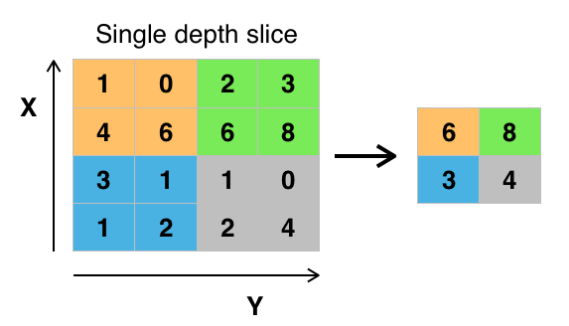

In [4]:
from IPython.display import Image
Image("17.png")

这是一个最大池化的例子，用了$2\times 2$的滤波器stride为2。四个$2\times 2$的颜色代表滤波器移动每个步长所产出的最大值。  
例如[[1,0],[4,6]]生成6，因为6是这4个数字中最大的。理论上，最大池化操作的好处是减小输入大小，使得神经网络能够专注于最重要的元素。最大池化只取覆盖区域中的最大值，其它的值都丢弃。  

TensorFlow提供了 tf.nn.max_pool()函数，用于对卷积层实现最大池化。  
>conv_layer = tf.nn.conv2d(input,weight, strides=[1,2,2,1],padding='SAME')  
conv_layer = tf.nn.bias_add(conv_layer, bias)
conv_layer = tf.nn.relu(conv_layer)
conv_layer = tf.nn.max_pool(conv_layer,ksize = [1,2,2,1],strides[1,2,2,1],padding = 'SAME')    

tf.nn.max_pool()函数实现最大池化时，ksize参数是滤波器大小，strides参数是步长。$2\times 2$的滤波器配合$2\times 2$的步长是常用设定。  

ksize和strides参数也被 构建为四个元素的列表，每个元素对应input tensor的一个维度([batch, height, width, channels]),对ksize和strides来说，batch和channel通常都设置成1。  

### 练习 
- 池化层总的来说是用来：  
减小输出大小，避免过拟合，它同样也减少了后续层中参数的数量。  
近期，池化层并不是很受青睐。部分原因是：  
现在的数据集又大又复杂，我们更关心欠拟合问题。  
Dropout 是一个更好的正则化方法。  
池化导致信息损失。想想最大池化的例子，n 个数字中我们只保留最大的，把余下的 n-1 完全舍弃了。

### 池化机制  
**设置**  
- 输入维度是$4\times4\times5(H\times W\times D)$  
- 滤波器大小是$2\times2(H\times W)$  
- stride的宽和高都是2 (S)  

新的高和宽的公式是：  

new_height = (input_height - filter_height)/S + 1  

new_width = (input_width - filter_width)/S + 1  

注意：池化层的输出深度与输入的深度相同。另外，池化操作是分别应用到每一个深度切片层。  
** 问题**： 池化输出结果，输出的维度大小是什么？   
** 答案**： 2x2x5，其中深度与输入保持不变 

In [13]:
## 对应代码  
input1 = tf.placeholder(tf.float32,(None,4,4,5))
filter_shape = [1,2,2,1]
strides = [1,2,2,1]
padding = 'VALID'
pool = tf.nn.max_pool(input1,filter_shape,strides,padding)

In [14]:
pool

<tf.Tensor 'MaxPool_1:0' shape=(?, 2, 2, 5) dtype=float32>

pool 的输出维度是 [1, 2, 2, 5]，即使把 padding 改成 'SAME' 也是一样。  
### 练习
(滤波器大小 2x2，stride 高和宽都是 2, 输出维度是 2x2x1)
- 最大池化：下列输入最大池化的结果是？  
[[[0, 1, 0.5, 10],  
   [2, 2.5, 1, -8],  
   [4, 0, 5, 6],  
   [15, 1, 2, 3]]]  
   
 **答案：**   
 [[2.5,10],[15,6]]  

- 平均池化的结果是？
 **答案：**   
 [[1.375,0.875],[5,4]]  

### $1\times 1$卷积
### Inception 模块

## TensorFlow 中的卷积网络 
### 数据集
这里我们导入 MNIST数据集，用一个方便的函数完成对数据集的batch,缩放和独热编码。

In [17]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('.', one_hot = True, reshape = False)

import tensorflow as tf

# parameters
learning_rate = 0.00001
epochs = 10
batch_size = 128

# 用来验证和计算准确率的样本数，内存不够时可以调小这个数字  
test_valid_size = 256

# 神经网络参数  
n_classes = 10
dropout = 0.75 # probability to keep units

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


### Weights and Biases

In [19]:
weights = {
    'wc1': tf.Variable(tf.random_normal([5,5,1,32])),
    'wc2': tf.Variable(tf.random_normal([5,5,32,64])),
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

### 卷积

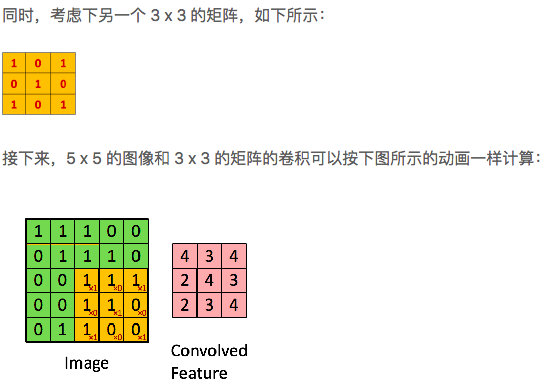

In [18]:
from IPython.display import Image
Image("22.png")

这是一个3x3的卷积滤波器的示例。以stride为1应用到一个范围在0-1之间的数据上。每一个3x3的部分与权值[[1,0,1],[0,1,0],[1,0,1]]做卷积，把偏置加上后得到右边的卷积特征。这里偏置为0。TensorFlow 中这是通过 tf.nn.conv2d( )和 tf.nn.bias_add( )来完成的。

In [20]:
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1,strides,strides,1],padding = 'SAME')
    x = tf.nn.bias_add(x,b)
    return tf.nn.relu(x)

在 TensorFlow 中，strides 是一个4个元素的序列；第一个位置表示 stride 的 batch 参数，最后一个位置表示 stride 的特征(feature)参数。最好的移除 batch 和特征(feature)的方法是你直接在数据集中把他们忽略，而不是使用 stride。要使用所有的 batch 和特征(feature)，你可以把第一个和最后一个元素设成1。  

中间两个元素指纵向(height)和横向(width)的 stride，之前也提到过 stride 通常是正方形，height = width。当别人说 stride 是 3 的时候，他们意思是 tf.nn.conv2d(x, W, strides=[1, 3, 3, 1])。  

为了更简洁，这里的代码用了tf.nn.bias_add() 来添加偏置。 tf.add() 这里不能使用，因为 tensors 的维度不同。  

### 最大池化

In [25]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x,ksize = [1,k,k,1],
                         strides=[1,k,k,1],padding='SAME')

### 模型
在下面的代码中，我们创建了3层来实现卷积，最大池化以及全链接层和输出层。每一层对维度的改变都写在注释里。例如第一层在卷积部分把图片从28x28x1变成了28x28x32。后面应该用了最大池化，每个样本变成了14x14x32。从 conv1 经过多层网络，最后到 output 生成了10个分类。

In [22]:
def conv_net(x,weights, biases,dropout):
    # Layer1 - 28*28*1 to 14*14*32
    conv1 = conv2d(x, weights['wc1'],biases['bc1'])
    conv1 = maxpool2d(conv1,k=2)
    
    # Layer2 - 14*14*32 to 7*7*64
    conv2 = conv2d(conv1,weights['wc2'],biases['bc2'])
    conv2 = maxpool2d(conv2,k=2)
    
    # Fully connected layer - 7*7*64 to 1024
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # output layer - class prediction- 1024 to 10
    out = tf.add(tf.matmul(fc1,weights['out']),biases['out'])
    
    return out

### Session
现在开始运行神经网络。 

In [ ]:
# tf graph inpu
x = tf.placeholder(tf.float32,[None,28,28,1])
y = tf.placeholder(tf.float32,[None,n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model
logits = conv_net(x,weights,biases,keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)

# Accuracy 
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        for batch in range(mnist.train.num_examples//batch_size):
            batch_x,batch_y = mnist.train.next_batch(batch_size)
            sess.run(optimizer,feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: dropout
            })
            
            # calculate batch loss and accuracy
            loss = sess.run(cost,feed_dict = {
                x: batch_x,
                y: batch_y,
                keep_prob: 1.0
            })
            valid_acc = sess.run(accuracy,feed_dict = {
                x: mnist.validation.images[:test_valid_size],
                y: mnist.validation.labels[:test_valid_size],
                keep_prob: 1.0
            })
            print('Epoch {:>2}, Batch {:>3} -'
                  'Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                epoch + 1,
                batch + 1,
                loss,
                valid_acc))
    test_acc = sess.run(accuracy, feed_dict ={
        x: mnist.validation.images[:test_valid_size],
        y: mnist.validation.labels[:test_valid_size],
        keep_prob: 1.0
    })
    print('Testing Accuracy: {}'.format(test_acc))    

Epoch  1, Batch   1 -Loss: 58183.7578 Validation Accuracy: 0.066406
Epoch  1, Batch   2 -Loss: 56619.1133 Validation Accuracy: 0.066406
Epoch  1, Batch   3 -Loss: 44376.2031 Validation Accuracy: 0.062500
Epoch  1, Batch   4 -Loss: 39136.1719 Validation Accuracy: 0.066406
Epoch  1, Batch   5 -Loss: 35783.4531 Validation Accuracy: 0.078125
Epoch  1, Batch   6 -Loss: 36763.4062 Validation Accuracy: 0.074219
Epoch  1, Batch   7 -Loss: 31010.2500 Validation Accuracy: 0.078125
Epoch  1, Batch   8 -Loss: 28682.1465 Validation Accuracy: 0.082031
Epoch  1, Batch   9 -Loss: 26191.0430 Validation Accuracy: 0.089844
Epoch  1, Batch  10 -Loss: 27356.4961 Validation Accuracy: 0.125000
Epoch  1, Batch  11 -Loss: 27356.7598 Validation Accuracy: 0.132812
Epoch  1, Batch  12 -Loss: 25031.2773 Validation Accuracy: 0.117188
Epoch  1, Batch  13 -Loss: 23685.2383 Validation Accuracy: 0.132812
Epoch  1, Batch  14 -Loss: 23256.7734 Validation Accuracy: 0.128906
Epoch  1, Batch  15 -Loss: 19789.3516 Validation

Epoch  1, Batch 122 -Loss:  6469.2866 Validation Accuracy: 0.519531
Epoch  1, Batch 123 -Loss:  3781.8850 Validation Accuracy: 0.531250
Epoch  1, Batch 124 -Loss:  5660.0352 Validation Accuracy: 0.527344
Epoch  1, Batch 125 -Loss:  5718.4590 Validation Accuracy: 0.535156
Epoch  1, Batch 126 -Loss:  4926.8203 Validation Accuracy: 0.523438
Epoch  1, Batch 127 -Loss:  3953.2559 Validation Accuracy: 0.531250
Epoch  1, Batch 128 -Loss:  5248.1104 Validation Accuracy: 0.523438
Epoch  1, Batch 129 -Loss:  4717.6372 Validation Accuracy: 0.527344
Epoch  1, Batch 130 -Loss:  4038.1924 Validation Accuracy: 0.527344
Epoch  1, Batch 131 -Loss:  4802.3623 Validation Accuracy: 0.527344
Epoch  1, Batch 132 -Loss:  4770.2773 Validation Accuracy: 0.535156
Epoch  1, Batch 133 -Loss:  4668.9648 Validation Accuracy: 0.523438
Epoch  1, Batch 134 -Loss:  5928.6489 Validation Accuracy: 0.531250
Epoch  1, Batch 135 -Loss:  3698.1030 Validation Accuracy: 0.539062
Epoch  1, Batch 136 -Loss:  4330.6543 Validation

Epoch  1, Batch 243 -Loss:  2701.9268 Validation Accuracy: 0.609375
Epoch  1, Batch 244 -Loss:  2297.9878 Validation Accuracy: 0.609375
Epoch  1, Batch 245 -Loss:  2593.4539 Validation Accuracy: 0.621094
Epoch  1, Batch 246 -Loss:  2051.5327 Validation Accuracy: 0.617188
Epoch  1, Batch 247 -Loss:  3729.2878 Validation Accuracy: 0.628906
Epoch  1, Batch 248 -Loss:  2605.1357 Validation Accuracy: 0.617188
Epoch  1, Batch 249 -Loss:  2731.0073 Validation Accuracy: 0.621094
Epoch  1, Batch 250 -Loss:  2533.0725 Validation Accuracy: 0.621094
Epoch  1, Batch 251 -Loss:  2636.6777 Validation Accuracy: 0.621094
Epoch  1, Batch 252 -Loss:  2818.9292 Validation Accuracy: 0.628906
Epoch  1, Batch 253 -Loss:  2959.6592 Validation Accuracy: 0.621094
Epoch  1, Batch 254 -Loss:  2765.3340 Validation Accuracy: 0.628906
Epoch  1, Batch 255 -Loss:  2687.1572 Validation Accuracy: 0.625000
Epoch  1, Batch 256 -Loss:  2868.2373 Validation Accuracy: 0.625000
Epoch  1, Batch 257 -Loss:  2767.5671 Validation

Epoch  1, Batch 364 -Loss:  1681.4395 Validation Accuracy: 0.707031
Epoch  1, Batch 365 -Loss:  2762.6387 Validation Accuracy: 0.714844
Epoch  1, Batch 366 -Loss:  2279.2773 Validation Accuracy: 0.710938
Epoch  1, Batch 367 -Loss:  2176.7766 Validation Accuracy: 0.707031
Epoch  1, Batch 368 -Loss:  2450.0928 Validation Accuracy: 0.695312
Epoch  1, Batch 369 -Loss:  1803.2119 Validation Accuracy: 0.683594
Epoch  1, Batch 370 -Loss:  1680.7305 Validation Accuracy: 0.687500
Epoch  1, Batch 371 -Loss:  1576.8157 Validation Accuracy: 0.695312
Epoch  1, Batch 372 -Loss:  1824.6392 Validation Accuracy: 0.691406
Epoch  1, Batch 373 -Loss:  1552.9868 Validation Accuracy: 0.691406
Epoch  1, Batch 374 -Loss:  1892.7466 Validation Accuracy: 0.695312
Epoch  1, Batch 375 -Loss:  1713.5431 Validation Accuracy: 0.695312
Epoch  1, Batch 376 -Loss:  2068.7349 Validation Accuracy: 0.691406
Epoch  1, Batch 377 -Loss:  1993.8638 Validation Accuracy: 0.691406
Epoch  1, Batch 378 -Loss:  2036.2185 Validation

Epoch  2, Batch  56 -Loss:  1638.9800 Validation Accuracy: 0.738281
Epoch  2, Batch  57 -Loss:   924.1204 Validation Accuracy: 0.738281
Epoch  2, Batch  58 -Loss:  1668.3540 Validation Accuracy: 0.738281
Epoch  2, Batch  59 -Loss:   915.0042 Validation Accuracy: 0.738281
Epoch  2, Batch  60 -Loss:  1235.1761 Validation Accuracy: 0.746094
Epoch  2, Batch  61 -Loss:   627.4915 Validation Accuracy: 0.746094
Epoch  2, Batch  62 -Loss:  2050.2295 Validation Accuracy: 0.742188
Epoch  2, Batch  63 -Loss:  1573.4417 Validation Accuracy: 0.742188
Epoch  2, Batch  64 -Loss:  1753.7247 Validation Accuracy: 0.730469
Epoch  2, Batch  65 -Loss:  1504.1605 Validation Accuracy: 0.730469
Epoch  2, Batch  66 -Loss:  1898.8468 Validation Accuracy: 0.730469
Epoch  2, Batch  67 -Loss:  1725.8896 Validation Accuracy: 0.734375
Epoch  2, Batch  68 -Loss:  1643.5781 Validation Accuracy: 0.742188
Epoch  2, Batch  69 -Loss:  1082.1183 Validation Accuracy: 0.746094
Epoch  2, Batch  70 -Loss:   806.3398 Validation

Epoch  2, Batch 177 -Loss:  1004.0153 Validation Accuracy: 0.753906
Epoch  2, Batch 178 -Loss:  1595.1638 Validation Accuracy: 0.757812
Epoch  2, Batch 179 -Loss:  1280.7551 Validation Accuracy: 0.757812
Epoch  2, Batch 180 -Loss:  1381.2461 Validation Accuracy: 0.757812
Epoch  2, Batch 181 -Loss:  1837.2136 Validation Accuracy: 0.753906
Epoch  2, Batch 182 -Loss:  1195.6680 Validation Accuracy: 0.753906
Epoch  2, Batch 183 -Loss:  1045.9841 Validation Accuracy: 0.753906
Epoch  2, Batch 184 -Loss:  1217.6621 Validation Accuracy: 0.753906
Epoch  2, Batch 185 -Loss:  1415.6179 Validation Accuracy: 0.757812
Epoch  2, Batch 186 -Loss:   731.7892 Validation Accuracy: 0.753906
Epoch  2, Batch 187 -Loss:  1565.7052 Validation Accuracy: 0.753906
Epoch  2, Batch 188 -Loss:  1523.8198 Validation Accuracy: 0.746094
Epoch  2, Batch 189 -Loss:  1222.9478 Validation Accuracy: 0.757812
Epoch  2, Batch 190 -Loss:  1147.5139 Validation Accuracy: 0.765625
Epoch  2, Batch 191 -Loss:   867.2179 Validation

Epoch  2, Batch 298 -Loss:  1225.1902 Validation Accuracy: 0.757812
Epoch  2, Batch 299 -Loss:  1172.9587 Validation Accuracy: 0.761719
Epoch  2, Batch 300 -Loss:   831.5956 Validation Accuracy: 0.757812
Epoch  2, Batch 301 -Loss:  1585.6814 Validation Accuracy: 0.765625
Epoch  2, Batch 302 -Loss:  1341.0679 Validation Accuracy: 0.761719
Epoch  2, Batch 303 -Loss:  1006.1763 Validation Accuracy: 0.769531
Epoch  2, Batch 304 -Loss:  1007.6929 Validation Accuracy: 0.769531
Epoch  2, Batch 305 -Loss:  1061.7524 Validation Accuracy: 0.761719
Epoch  2, Batch 306 -Loss:   934.4710 Validation Accuracy: 0.761719
Epoch  2, Batch 307 -Loss:   970.0588 Validation Accuracy: 0.757812
Epoch  2, Batch 308 -Loss:   903.0774 Validation Accuracy: 0.761719
Epoch  2, Batch 309 -Loss:   948.4838 Validation Accuracy: 0.757812
Epoch  2, Batch 310 -Loss:   960.9249 Validation Accuracy: 0.765625
Epoch  2, Batch 311 -Loss:  1000.6785 Validation Accuracy: 0.777344
Epoch  2, Batch 312 -Loss:   814.9415 Validation

Epoch  2, Batch 419 -Loss:   927.5598 Validation Accuracy: 0.792969
Epoch  2, Batch 420 -Loss:   807.7454 Validation Accuracy: 0.781250
Epoch  2, Batch 421 -Loss:   874.0652 Validation Accuracy: 0.777344
Epoch  2, Batch 422 -Loss:   802.1481 Validation Accuracy: 0.777344
Epoch  2, Batch 423 -Loss:   908.8094 Validation Accuracy: 0.792969
Epoch  2, Batch 424 -Loss:   910.2307 Validation Accuracy: 0.789062
Epoch  2, Batch 425 -Loss:   997.0400 Validation Accuracy: 0.785156
Epoch  2, Batch 426 -Loss:  1159.5693 Validation Accuracy: 0.777344
Epoch  2, Batch 427 -Loss:   994.1900 Validation Accuracy: 0.781250
Epoch  2, Batch 428 -Loss:   610.2496 Validation Accuracy: 0.777344
Epoch  2, Batch 429 -Loss:   879.3966 Validation Accuracy: 0.769531
Epoch  3, Batch   1 -Loss:  1622.1733 Validation Accuracy: 0.773438
Epoch  3, Batch   2 -Loss:  1180.5989 Validation Accuracy: 0.773438
Epoch  3, Batch   3 -Loss:   918.9637 Validation Accuracy: 0.773438
Epoch  3, Batch   4 -Loss:   743.3000 Validation

Epoch  3, Batch 111 -Loss:   905.5923 Validation Accuracy: 0.781250
Epoch  3, Batch 112 -Loss:   487.4238 Validation Accuracy: 0.773438
Epoch  3, Batch 113 -Loss:   444.5400 Validation Accuracy: 0.773438
Epoch  3, Batch 114 -Loss:   719.0754 Validation Accuracy: 0.773438
Epoch  3, Batch 115 -Loss:   775.1401 Validation Accuracy: 0.773438
Epoch  3, Batch 116 -Loss:   936.2378 Validation Accuracy: 0.777344
Epoch  3, Batch 117 -Loss:  1065.1628 Validation Accuracy: 0.781250
Epoch  3, Batch 118 -Loss:   735.6965 Validation Accuracy: 0.777344
Epoch  3, Batch 119 -Loss:   807.0980 Validation Accuracy: 0.777344
Epoch  3, Batch 120 -Loss:   800.4615 Validation Accuracy: 0.777344
Epoch  3, Batch 121 -Loss:   897.3947 Validation Accuracy: 0.777344
Epoch  3, Batch 122 -Loss:   849.2043 Validation Accuracy: 0.773438
Epoch  3, Batch 123 -Loss:   632.2454 Validation Accuracy: 0.773438
Epoch  3, Batch 124 -Loss:   831.1674 Validation Accuracy: 0.777344
Epoch  3, Batch 125 -Loss:   664.0560 Validation

Epoch  3, Batch 232 -Loss:   677.4342 Validation Accuracy: 0.789062
Epoch  3, Batch 233 -Loss:   868.3983 Validation Accuracy: 0.789062
Epoch  3, Batch 234 -Loss:   702.9750 Validation Accuracy: 0.792969
Epoch  3, Batch 235 -Loss:   519.3180 Validation Accuracy: 0.789062
Epoch  3, Batch 236 -Loss:   639.4816 Validation Accuracy: 0.789062
Epoch  3, Batch 237 -Loss:   743.8566 Validation Accuracy: 0.792969
Epoch  3, Batch 238 -Loss:   763.6416 Validation Accuracy: 0.792969
Epoch  3, Batch 239 -Loss:   594.1833 Validation Accuracy: 0.792969
Epoch  3, Batch 240 -Loss:   656.2734 Validation Accuracy: 0.792969
Epoch  3, Batch 241 -Loss:   599.8658 Validation Accuracy: 0.800781
Epoch  3, Batch 242 -Loss:   871.2238 Validation Accuracy: 0.804688
Epoch  3, Batch 243 -Loss:   516.1422 Validation Accuracy: 0.800781
Epoch  3, Batch 244 -Loss:   706.9598 Validation Accuracy: 0.800781
Epoch  3, Batch 245 -Loss:   551.6025 Validation Accuracy: 0.789062
Epoch  3, Batch 246 -Loss:   413.0356 Validation

Epoch  3, Batch 353 -Loss:   684.6464 Validation Accuracy: 0.789062
Epoch  3, Batch 354 -Loss:   666.5912 Validation Accuracy: 0.785156
Epoch  3, Batch 355 -Loss:   482.3605 Validation Accuracy: 0.781250
Epoch  3, Batch 356 -Loss:   609.0314 Validation Accuracy: 0.781250
Epoch  3, Batch 357 -Loss:   706.7773 Validation Accuracy: 0.792969
Epoch  3, Batch 358 -Loss:   543.7516 Validation Accuracy: 0.796875
Epoch  3, Batch 359 -Loss:   996.9180 Validation Accuracy: 0.796875
Epoch  3, Batch 360 -Loss:   791.8373 Validation Accuracy: 0.792969
Epoch  3, Batch 361 -Loss:   705.5332 Validation Accuracy: 0.792969
Epoch  3, Batch 362 -Loss:   560.4820 Validation Accuracy: 0.789062
Epoch  3, Batch 363 -Loss:   560.9946 Validation Accuracy: 0.789062
Epoch  3, Batch 364 -Loss:   678.5937 Validation Accuracy: 0.792969
Epoch  3, Batch 365 -Loss:   441.1638 Validation Accuracy: 0.792969
Epoch  3, Batch 366 -Loss:   712.0349 Validation Accuracy: 0.792969
Epoch  3, Batch 367 -Loss:   830.2184 Validation

### 练习

In [ ]:
"""
Setup the strides, padding and filter weight/bias such that
the output shape is (1, 2, 2, 3).
"""
import tensorflow as tf
import numpy as np

# `tf.nn.conv2d` requires the input be 4D (batch_size, height, width, depth)
# (1, 4, 4, 1)
x = np.array([
    [0, 1, 0.5, 10],
    [2, 2.5, 1, -8],
    [4, 0, 5, 6],
    [15, 1, 2, 3]], dtype=np.float32).reshape((1, 4, 4, 1))
X = tf.constant(x)


def conv2d(input):
    # Filter (weights and bias)
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    # The shape of the filter bias is (output_depth,)
    # TODO: Define the filter weights `F_W` and filter bias `F_b`.
    # NOTE: Remember to wrap them in `tf.Variable`, they are trainable parameters after all.
    F_W = tf.Variable(tf.truncated_normal((2,2,1,3)))
    F_b = tf.Variable(tf.zeros(3))
    # TODO: Set the stride for each dimension (batch_size, height, width, depth)
    strides = [1, 2, 2, 1]
    # TODO: set the padding, either 'VALID' or 'SAME'.
    padding = 'VALID'
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#conv2d
    # `tf.nn.conv2d` does not include the bias computation so we have to add it ourselves after.
    return tf.nn.conv2d(input, F_W, strides, padding) + F_b

out = conv2d(X)

### 在 TensorFlow 中使用池化层

In [ ]:
"""
Set the values to `strides` and `ksize` such that
the output shape after pooling is (1, 2, 2, 1).
"""
import tensorflow as tf
import numpy as np

# `tf.nn.max_pool` requires the input be 4D (batch_size, height, width, depth)
# (1, 4, 4, 1)
x = np.array([
    [0, 1, 0.5, 10],
    [2, 2.5, 1, -8],
    [4, 0, 5, 6],
    [15, 1, 2, 3]], dtype=np.float32).reshape((1, 4, 4, 1))
X = tf.constant(x)

def maxpool(input):
    # TODO: Set the ksize (filter size) for each dimension (batch_size, height, width, depth)
    ksize = [1, 2, 2,1]
    # TODO: Set the stride for each dimension (batch_size, height, width, depth)
    strides = [1, 2, 2, 1]
    # TODO: set the padding, either 'VALID' or 'SAME'.
    padding = 'VALID'
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#max_pool
    return tf.nn.max_pool(input, ksize, strides, padding)
    
out = maxpool(X)